In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-02-02 22:51:45.201336: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-02 22:51:45.209036: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-02 22:51:45.275817: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-02 22:51:45.326364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738515105.375500  150953 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738515105.38

In [19]:
dataset_path = "data.pkl"
print(dataset_path)

data.pkl


In [20]:
import pickle
with open(dataset_path, 'rb') as file:
    data = pickle.load(file)

In [21]:
(train_imgs, train_labels), (val_imgs, val_labels) = data

train_imgs = train_imgs.astype('float32') / 255.0
val_imgs = val_imgs.astype('float32') / 255.0

print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_imgs.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training images shape: (887, 256, 256, 3)
Training labels shape: (887,)
Validation images shape: (222, 256, 256, 3)
Validation labels shape: (222,)


In [22]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_hot = to_categorical(train_labels, num_classes=4)
val_labels_hot = to_categorical(val_labels, num_classes=4)


In [23]:
class_names = ['ashfaq', 'khalid', 'rifat', 'shafin']

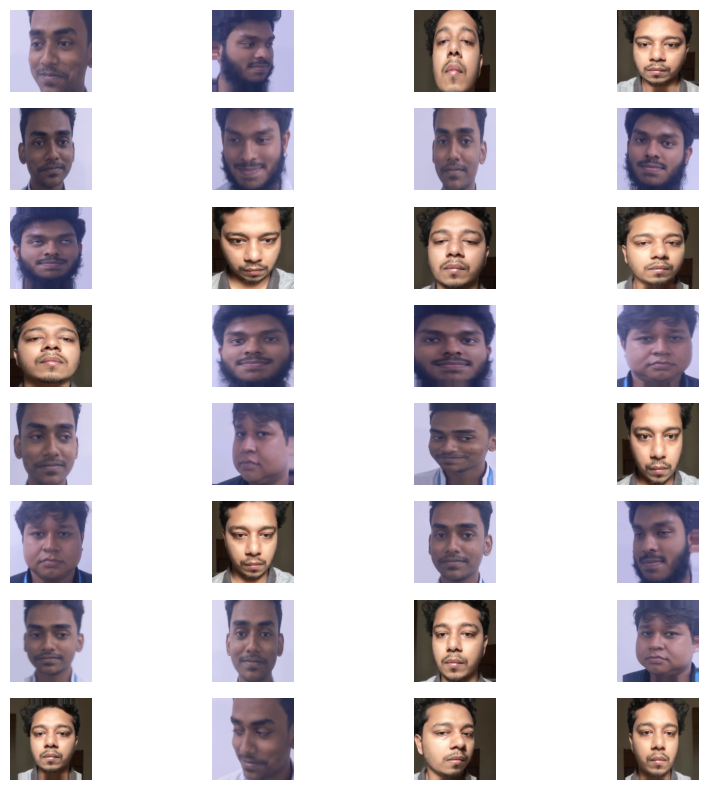

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_imgs)

# Generate a batch of augmented images from the datagen
augmented_images, _ = next(datagen.flow(train_imgs, train_labels_hot, batch_size=32)) 

plt.figure(figsize=(10, 10)) 

for i in range(32):
    plt.subplot(8, 4, i + 1)  
    plt.imshow(augmented_images[i])
    plt.axis('off') 

plt.show()

In [25]:
from tensorflow.keras import models, layers, applications, optimizers

# Load a pre-trained model (e.g., MobileNetV2) without the top classification layer
base_model = applications.MobileNetV2(
    input_shape=(256, 256, 3),  # Input shape for your images
    include_top=False,          # Exclude the top classification layer
    weights='imagenet'          # Load weights pre-trained on ImageNet
)

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Create the transfer learning model
model = models.Sequential([
    # Pre-trained base model
    base_model,

    # Add custom layers for face recognition
    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions
    layers.Dense(128, activation='relu'),  # Dense layer for feature extraction
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Unfreeze the top layers of the base model
base_model.trainable = True

# Fine-tune only the last few layers of the base model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the updated model summary
model.summary()

/tmp/ipykernel_150953/1508689800.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 896,964 (3.42 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    datagen.flow(train_imgs, train_labels_hot, batch_size=6),
    epochs=50,
    validation_data=(val_imgs, val_labels_hot),
    callbacks=[early_stopping],
)

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.3387 - loss: 1.4228 - val_accuracy: 0.7432 - val_loss: 1.0799
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.8056 - loss: 0.6826 - val_accuracy: 0.7928 - val_loss: 0.6238
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9090 - loss: 0.4258 - val_accuracy: 0.9234 - val_loss: 0.3697
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.9290 - loss: 0.3027 - val_accuracy: 0.9955 - val_loss: 0.2202
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step - accuracy: 0.9583 - loss: 0.2303 - val_accuracy: 1.0000 - val_loss: 0.1302
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.9759 - loss: 0.1656 - val_accuracy: 1.0000 - val_loss: 0.0793
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.9639 - loss: 0.1482 - val_accuracy: 1.0000 - val_loss: 0.0515
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.9741 - loss: 0

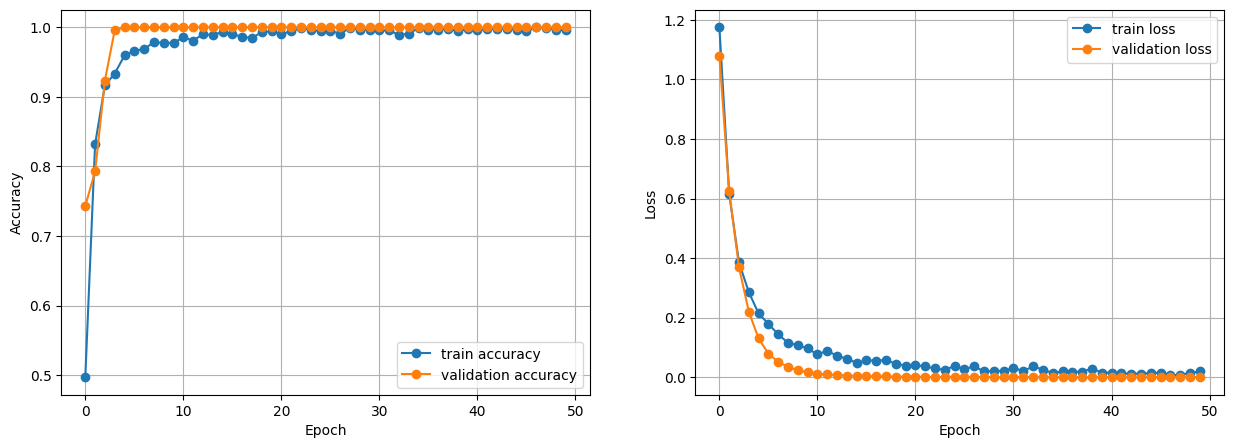

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [15]:
predictions = model.predict(val_imgs)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 675ms/step


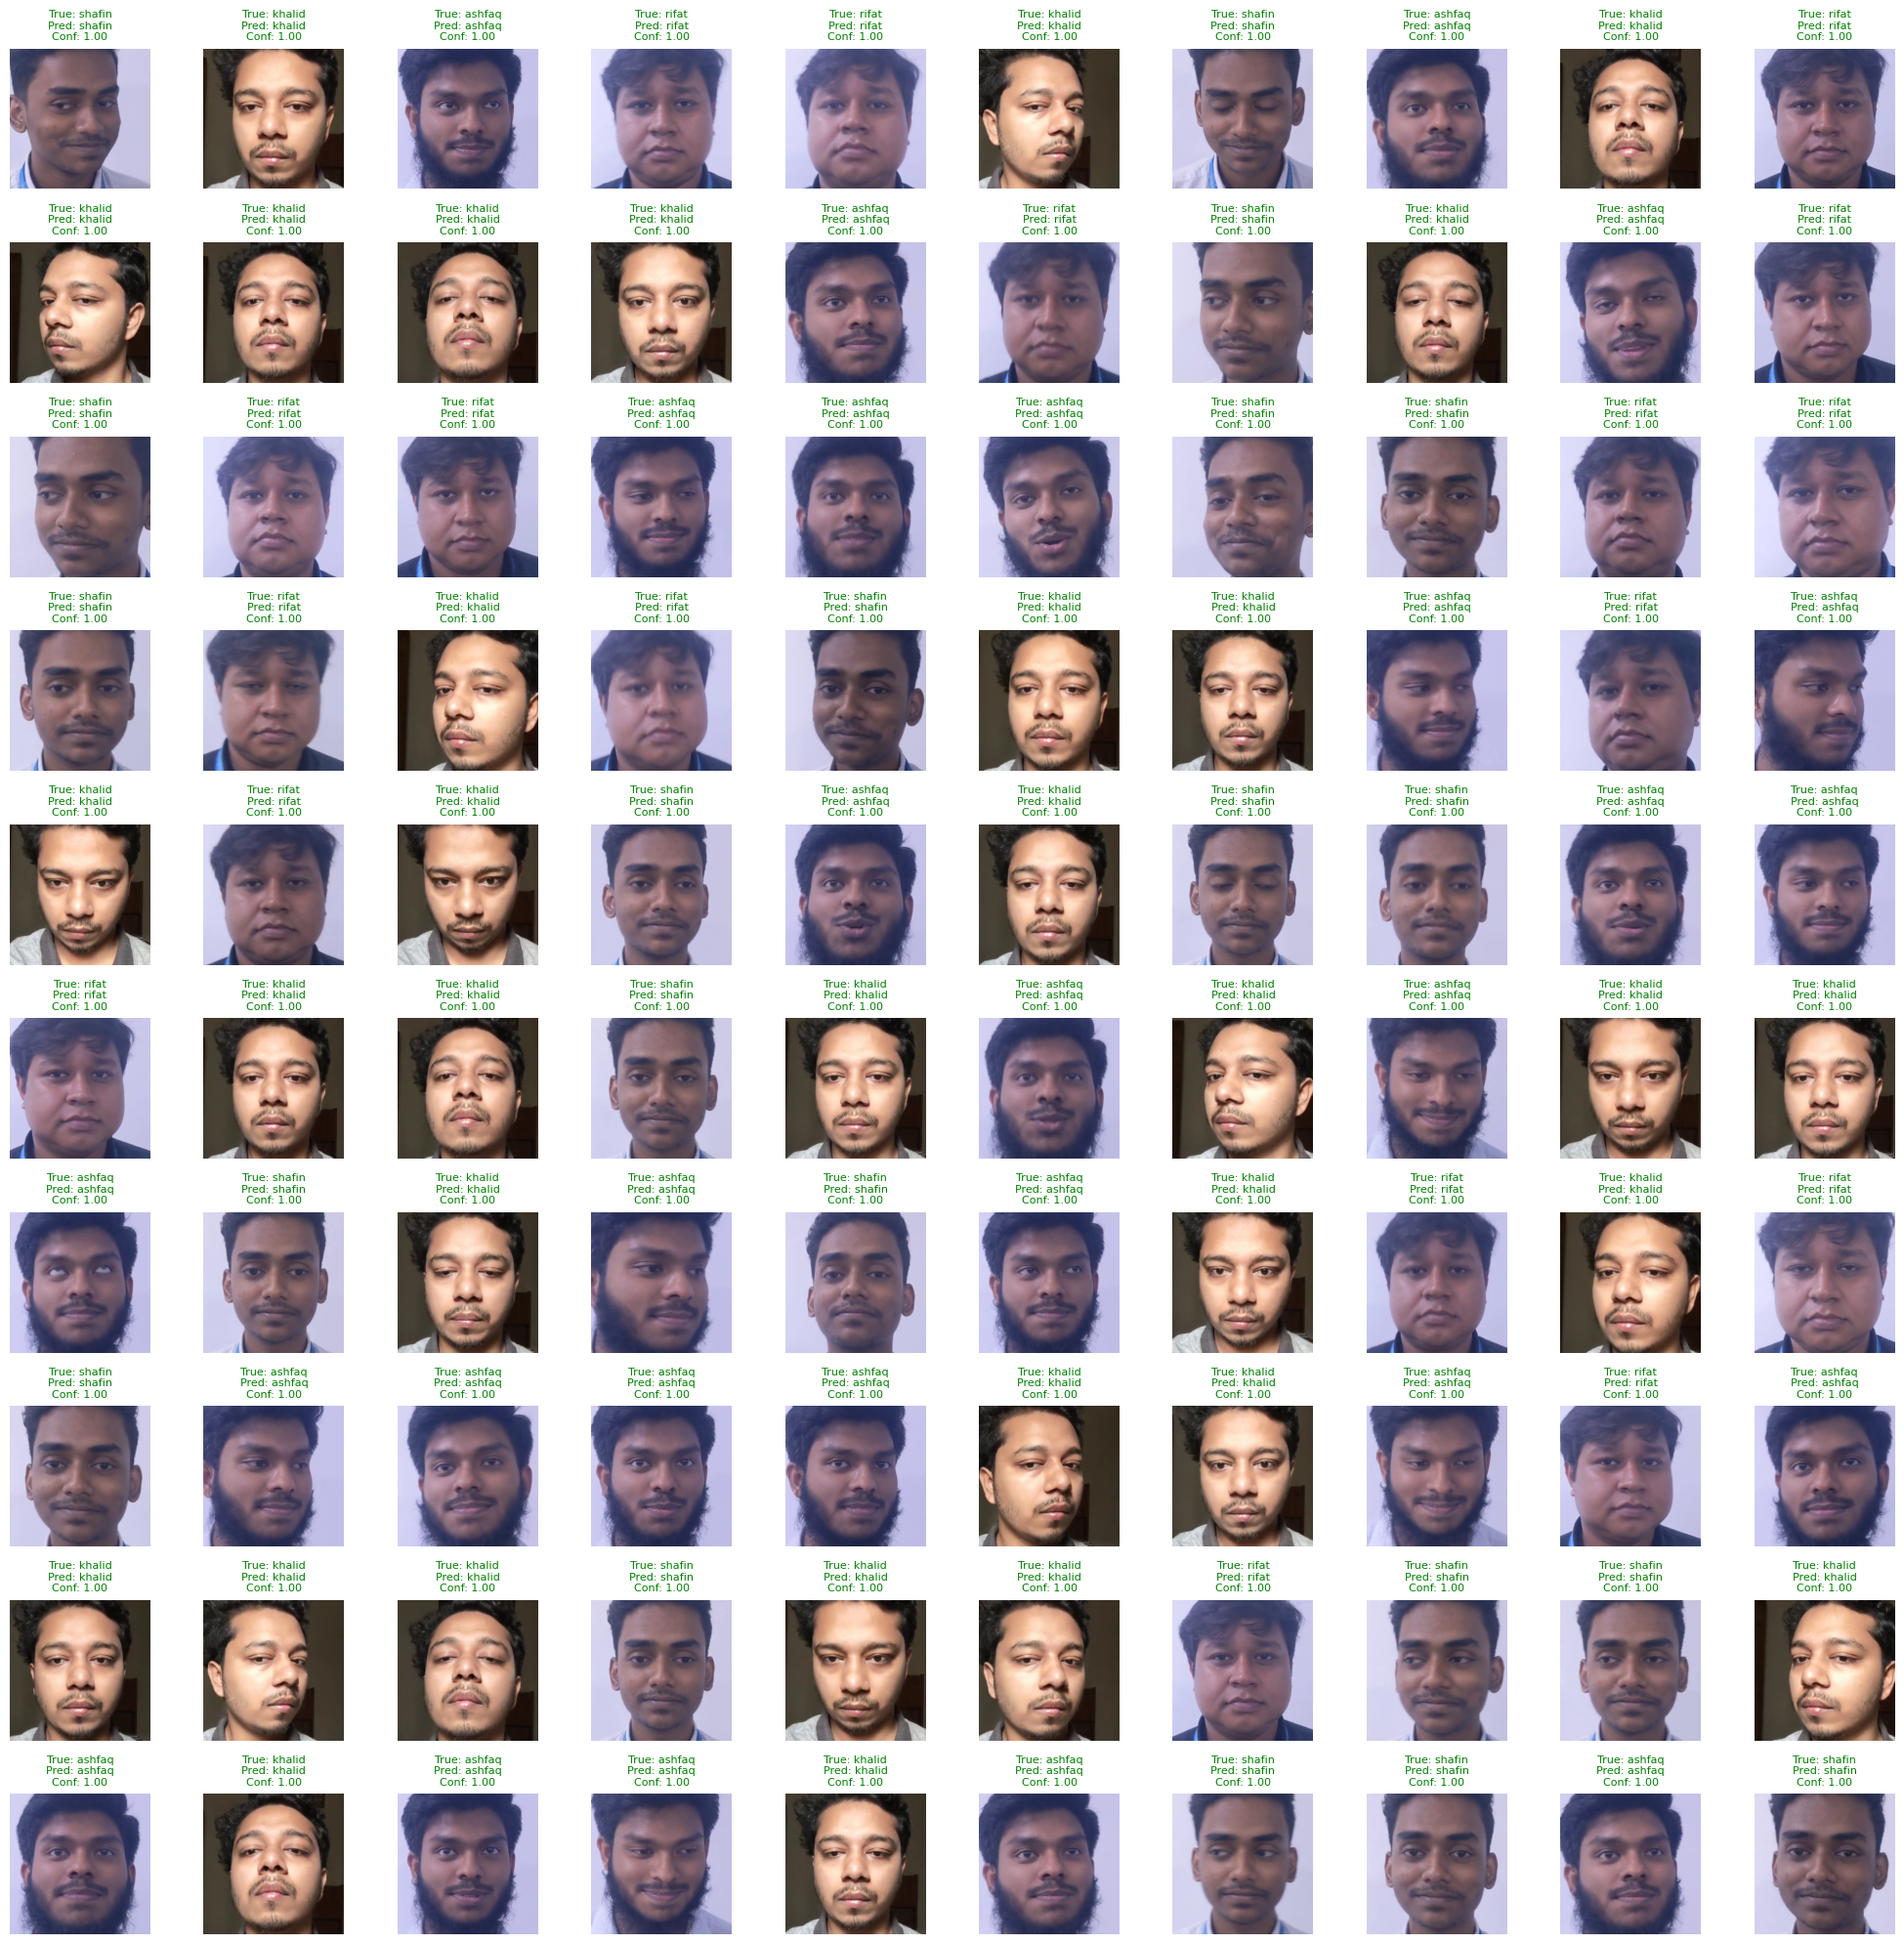

In [26]:
predicted_classes = np.argmax(predictions, axis=1)
confidence_levels = np.max(predictions, axis=1)

fig, axes = plt.subplots(10, 10, figsize=(20, 20))  
axes = axes.ravel()  

for i in range(100):  
    axes[i].imshow(val_imgs[i]) 
    axes[i].axis('off')  

    true_label = class_names[val_labels[i]]
    predicted_label = class_names[predicted_classes[i]]
    confidence = confidence_levels[i]

    color = "green" if predicted_classes[i] == val_labels[i] else "red"

    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", color=color, fontsize=8)

plt.tight_layout()
plt.show()


In [17]:
model.save('face_recognition_model.keras')

In [18]:
with open('class_labels.pkl', 'wb') as file:
    pickle.dump(class_names, file)